In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from PIL import Image
import time

/home/riccardo/anaconda3/envs/siv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   

In [3]:
def smart_mkdir(path):
    created = False

    if not os.path.exists(path):
        os.makedirs(path)
        created = True

    return created

In [4]:
# create tensorboard dir
smart_mkdir("tensorboard")

True

In [5]:
writer = SummaryWriter("tensorboard")

In [6]:
data_dir = os.path.join('..','data','gt_bbox')

## Generate dataset

In [10]:
# img_list = os.listdir(data_dir)
# img_list.sort()

In [11]:
# img_list[:5]

['0001_c1s1_001051_00.jpg',
 '0001_c1s1_002301_00.jpg',
 '0001_c1s1_002401_00.jpg',
 '0001_c1s1_009376_00.jpg',
 '0001_c1s2_037091_00.jpg']

In [1]:
# img_dict = [{'tid':img.split('_')[0],'img':img} for img in img_list if img.split('.')[-1] == 'jpg']

In [13]:
# data = pd.DataFrame(img_dict)

In [14]:
# data

,tid,img
0,0001,0001_c1s1_001051_00.jpg
1,0001,0001_c1s1_002301_00.jpg
2,0001,0001_c1s1_002401_00.jpg
3,0001,0001_c1s1_009376_00.jpg
4,0001,0001_c1s2_037091_00.jpg
...,...,...
25254,1501,1501_c3s3_075369_00.jpg
25255,1501,1501_c3s3_075394_00.jpg
25256,1501,1501_c3s3_075419_00.jpg
25257,1501,1501_c6s4_001877_00.jpg


In [15]:
# data.to_csv(os.path.join('..','data','dataset.csv'),header=None,index=None)

## Load dataset

In [7]:
data = pd.read_csv(os.path.join('..','data','dataset.csv'),names=['tid','img'])

In [8]:
data.head()

,tid,img
0,1,0001_c1s1_001051_00.jpg
1,1,0001_c1s1_002301_00.jpg
2,1,0001_c1s1_002401_00.jpg
3,1,0001_c1s1_009376_00.jpg
4,1,0001_c1s2_037091_00.jpg


In [9]:
n_tid = pd.unique(data["tid"]).shape[0]
n_tid

1501

## Split data Train/Val

In [10]:
idx_path = "txt"
smart_mkdir(idx_path)

True

In [11]:
np.random.seed(136)

perm_ix = np.random.permutation(range(len(data)))
train_ix = np.array(list(perm_ix[:int(len(perm_ix) * 0.8)]))
test_ix = np.array(list(perm_ix[int(len(perm_ix) * 0.8):]))

np.savetxt(os.path.join(idx_path, 'train_ix.txt'), train_ix)
np.savetxt(os.path.join(idx_path, 'test_ix.txt'), test_ix)

print(f"Train:{len(train_ix)}, Valid:{len(test_ix)}")

Train:20207, Valid:5052


In [12]:
class SNN_dataset(Dataset):
    def __init__(self, _data, _data_dir, index):
        self.data = _data.filter(
            items=index, axis=0).reset_index(drop=True).copy()
        self.data_dir = _data_dir
        self.preprocess = transforms.Compose([
            transforms.Resize((128,64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # get img1 class and img_filename
        c, img = data.iloc[index]
        img_1 = Image.open(os.path.join(self.data_dir, img))

        # select img2 with 50% of equal class
        if np.random.rand() > 0.5:
            # img of same class
            target = torch.tensor(1, dtype=torch.float)

            # filter to get different image with same class
            possible_imgs = data.loc[(data['tid'] == c) &
                                     (data['img'] != img)].reset_index(drop=True).copy()

            c2, img2 = possible_imgs.loc[np.random.randint(len(possible_imgs))]

            img_2 = Image.open(os.path.join(
                self.data_dir, img2))

        else:
            # img of different class
            target = torch.tensor(0, dtype=torch.float)

            # filter to get image with different class
            possible_imgs = data.loc[(data['tid'] != c)].reset_index(
                drop=True).copy()

            c2, img2 = possible_imgs.loc[np.random.randint(len(possible_imgs))]

            img_2 = Image.open(os.path.join(
                self.data_dir, img2))

        return self.preprocess(img_1), self.preprocess(img_2), target


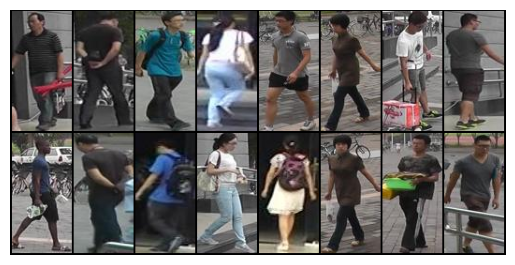

[0. 1. 1. 1. 0. 1. 0. 1.]


In [13]:
data_loader_vis= DataLoader(
    SNN_dataset(data, data_dir, train_ix), batch_size=8, shuffle=True, drop_last=True)
dataiter = iter(data_loader_vis)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [14]:
batch_size = 128

train_dataset = SNN_dataset(data, data_dir, train_ix)
data_loader_train = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = SNN_dataset(data, data_dir, test_ix)
data_loader_test = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)


In [15]:
class SNN_classifier(nn.Module):
    def __init__(self):
        super(SNN_classifier, self).__init__()

        # Resnet18 is way more smaller than densenet121
        self.resnet18 = torchvision.models.resnet18(weights=None)
        # remove linear layer to use the fully connected NN
        self.resnet18 = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))

        # Resnet18 Linear layer input shape is 512


        self.fc = nn.Sequential(
            nn.Linear(512,1),
            nn.ReLU()
        )

        self.sigmoid = nn.Sigmoid()
    
    def forward_resnet18(self, x):
        y = self.resnet18(x)
        y = y.view(y.shape[0], -1)  # reshape to have shape(1,512)
        return y
    
    def forward(self, img1, img2_fv):
        # extract features vector for img1
        # img2_fv is a pre extracted features vector
        img1_fv = self.forward_resnet18(img1)

        # calculate euclidian distance of f(img1), f(img2)
        x = torch.pow(torch.abs(img1_fv-img2_fv),2)
        x = self.fc(x)
        
        y = self.sigmoid(x) # get probability

        return y

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
snn_classifier = SNN_classifier().to(device)

In [18]:
criterion = nn.BCELoss()
lr = 1e-3
optimizer = torch.optim.Adam(snn_classifier.parameters(),lr=lr,weight_decay=1e-5)

In [19]:
train_loss = []
valid_loss = []

In [20]:
start_epoch = 0
n_epochs = start_epoch+100

In [21]:
smart_mkdir('weights')

True

In [22]:
for epoch in range(start_epoch,n_epochs):

    epoch_train_loss = []
    snn_classifier.train()

    start = time.time()
    for batch_id, (imgs1, imgs2, targets) in enumerate(data_loader_train):

        imgs1, imgs2_fv, targets = imgs1.to(device), snn_classifier.forward_resnet18(
            imgs2.to(device)), targets.to(device)

        optimizer.zero_grad()

        output = snn_classifier(imgs1, imgs2_fv).squeeze(1)
        loss = criterion(output, targets)
        loss.backward()
        epoch_train_loss.append(loss.item())
        optimizer.step()
    
    train_loss.append(sum(epoch_train_loss)/len(epoch_train_loss))
    writer.add_scalar('Loss/train', train_loss[-1], epoch)

    epoch_valid_loss = []
    snn_classifier.eval()

    for batch_id, (imgs1, imgs2, targets) in enumerate(data_loader_test):
        
        imgs1, imgs2_fv, targets = imgs1.to(device), snn_classifier.forward_resnet18(
            imgs2.to(device)), targets.to(device)

        output = snn_classifier(imgs1, imgs2_fv).squeeze(1)
        loss = criterion(output, targets)
        epoch_valid_loss.append(loss.item())
    
    valid_loss.append(sum(epoch_valid_loss)/len(epoch_valid_loss))
    writer.add_scalar('Loss/validation', valid_loss[-1], epoch)
    
    print(f"Epoch {epoch} in {time.time()-start}: train loss={train_loss[-1]}, valid loss={valid_loss[-1]}")

    if ((epoch+1) % 1) == 0:
        print("Saving model")
        torch.save(snn_classifier.state_dict(),
                   os.path.join('weights', f"model_{epoch+1}.pt"))
        print("----------------------------")

torch.save(snn_classifier.state_dict(),
           os.path.join('weights', 'model_final.pt'))


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 3.82 GiB total capacity; 2.51 GiB already allocated; 30.00 MiB free; 2.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.figure(figsize=(20, 10))

train_l = len(train_loss)
valid_l = len(valid_loss)

plt.plot(np.linspace(1, train_l, train_l).astype(
    int), train_loss, label="Training")

plt.plot(np.linspace(1, valid_l, valid_l).astype(
    int), valid_loss, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.savefig(os.path.join("weights","training.png"))